In [1]:
!pip install matplotlib seaborn wordcloud

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
sns.set_style('dark')

# Spark intialization

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

In [5]:
spark = SparkSession.builder\
    .appName('main-app-linked')\
    .getOrCreate()

# Data preparation

### While for skills and summaries you can do with strings, you neeed to parse dates and timestamps

In [6]:
skills = spark.read\
    .option('header', 'True')\
    .csv('data/job_skills.csv')

summaries = spark.read\
    .option('header', 'True')\
    .csv('data/job_summary.csv')

postings = spark.read\
    .option('header', 'True')\
    .option('inferSchema', 'True')\
    .csv('data/linkedin_job_postings.csv')

In [7]:
skills.printSchema()

root
 |-- job_link: string (nullable = true)
 |-- job_skills: string (nullable = true)



In [8]:
summaries.printSchema()

root
 |-- job_link: string (nullable = true)
 |-- job_summary: string (nullable = true)



In [9]:
postings.printSchema()

root
 |-- job_link: string (nullable = true)
 |-- last_processed_time: string (nullable = true)
 |-- got_summary: string (nullable = true)
 |-- got_ner: string (nullable = true)
 |-- is_being_worked: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- company: string (nullable = true)
 |-- job_location: string (nullable = true)
 |-- first_seen: string (nullable = true)
 |-- search_city: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- search_position: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- job_type: string (nullable = true)



In [10]:
postings.show(5, truncate=10)

+----------+-------------------+-----------+-------+---------------+----------+----------+------------+----------+-----------+--------------+---------------+----------+--------+
|  job_link|last_processed_time|got_summary|got_ner|is_being_worked| job_title|   company|job_location|first_seen|search_city|search_country|search_position| job_level|job_type|
+----------+-------------------+-----------+-------+---------------+----------+----------+------------+----------+-----------+--------------+---------------+----------+--------+
|https:/...|         2024-01...|          t|      t|              f|Account...|        BD|  San Die...|2024-01-15|   Coronado|    United ...|     Color M...|Mid senior|  Onsite|
|https:/...|         2024-01...|          t|      t|              f|Registe...|Trinity...|  Norton ...|2024-01-14| Grand H...|    United ...|     Directo...|Mid senior|  Onsite|
|https:/...|         2024-01...|          t|      t|              f|RESTAUR...|Wasatch...|   Sandy, UT|2024-01

### Infering schema did not work for postings, we possibly need to clean the data

In [11]:
def transform_time_postings(postings): 
    return postings.withColumn('first_seen', 
                        to_date(col('first_seen'),'yyyy-MM-dd'))\
            .withColumn('last_processed_time',
                        to_timestamp(col('last_processed_time')))

In [12]:
def transform_booleans_postings(postings):
    return postings.withColumn('got_summary',
                               col('got_summary') == 't')\
                    .withColumn('got_ner',
                                col('got_summary') == 't')\
                    .withColumn('is_being_worked',
                                col('is_being_worked') == 't')

In [13]:
postings = postings.transform(transform_time_postings)\
                   .transform(transform_booleans_postings)

### Since the data is not being prepared for long time analytics or ML, I will not factorize `job_level` and `job_type` columns, but in those scenarios this should be done to use less space and pre-prepare data for ML

### There was a problem reading the summaries csv with Spark

In [14]:
summaries = spark.read\
    .option('header', 'True')\
    .option('multiline', 'true')\
    .option("quote", "\"")\
    .option("escape", "\"")\
    .csv('data/job_summary.csv')

summaries.show(5, truncate=50)

+--------------------------------------------------+--------------------------------------------------+
|                                          job_link|                                       job_summary|
+--------------------------------------------------+--------------------------------------------------+
|https://www.linkedin.com/jobs/view/restaurant-m...|Rock N Roll Sushi is hiring a Restaurant Manage...|
|https://www.linkedin.com/jobs/view/med-surg-reg...|Schedule\n: PRN is required minimum 12 hours pe...|
|https://www.linkedin.com/jobs/view/registered-n...|Description\nIntroduction\nAre you looking for ...|
|https://uk.linkedin.com/jobs/view/commercial-ac...|Commercial account executive\nSheffield\nFull t...|
|https://www.linkedin.com/jobs/view/store-manage...|Address:\nUSA-CT-Newington-44 Fenn Road\nStore ...|
+--------------------------------------------------+--------------------------------------------------+
only showing top 5 rows



### I have to be sure, that the data is in correct format with regex: `job_link` should start with http:// or https:// or a URL (optional characters).linkedin.com

In [15]:
# Run this to make sure, that the format is correct(didn't break later)
# summaries.filter(~col('job_link').rlike(r'(http(s)?://)?\w+\.linkedin.*')).show(5)

### Now, for `skills` DataFrame I can also expore the number of skills and, If the biggest number isn't to big: turn it into an ArrayType or a UserDefinedType(a set esssentially)

In [16]:
skills.show(5, truncate=100)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                            job_link|                                                                                          job_skills|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|     https://www.linkedin.com/jobs/view/housekeeper-i-pt-at-jacksonville-state-university-3802280436|Building Custodial Services, Cleaning, Janitorial Services, Materials Handling, Housekeeping, San...|
|https://www.linkedin.com/jobs/view/assistant-general-manager-huntington-4131-at-ruby-tuesday-3575...|Customer service, Restaurant management, Food safety, Training, Supervision, Sched

In [17]:
skills.withColumn('num_skills', 
                  length('job_skills') - length(replace('job_skills', lit(','), lit('')))) \
    .select(max('num_skills'))\
    .collect()

[Row(max(num_skills)=462)]

### Because of the massive amount of skills that are listed in some cases, we cannot turn `job_skills` into an array without additional work. I will take the first 200 (20 chars/per skills * 10 skills) characters from the `job_skills` column and convert them into  string arrays.

In [18]:
skills.select(split(
    substring('job_skills', 0, 200), ','))\
    .show(5, truncate=200)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                                                                                             split(substring(job_skills, 0, 200), ,, -1)|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[Building Custodial Services,  Cleaning,  Janitorial Services,  Materials Handling,  Housekeeping,  Sanitation,  Waste Management,  Floor Maintenance,  Equipment Maintenance,  Safety Protocols,  Co...|
|[Customer service,  Restaurant management,  Food safety,  Training,  Supervision,  Scheduling,  Inventory,  Cost control,  Sales,  Communication,  Problemsolving,  Leadership,  Motivation

In [19]:
skills.withColumn('n_top_skills', size(split(
    substring('job_skills', 0, 200), ',')))\
    .select(max(col('n_top_skills')), min(col('n_top_skills')), avg(col('n_top_skills')))\
    .collect()

[Row(max(n_top_skills)=30, min(n_top_skills)=-1, avg(n_top_skills)=11.04446378032384)]

In [20]:
skills = skills.withColumn('job_skills', split(
    substring('job_skills', 0, 200), ','))

### Another data preparation step is to fix the foreign keys by indexing `job_link`s, since this column is primary and foreign keys for all dataframes.

In [21]:
def hash_links(df):
    return df.withColumn('link_hashed',
                         xxhash64('job_link'))

In [22]:
skills = skills.transform(hash_links)
summaries = summaries.transform(hash_links)
postings = postings.transform(hash_links)

# Data analysis

In [23]:
postings.select(min('last_processed_time'), 
                max('last_processed_time')).collect()

[Row(min(last_processed_time)=datetime.datetime(2024, 1, 19, 9, 45, 9, 215838), max(last_processed_time)=datetime.datetime(2024, 1, 21, 17, 37, 21, 80491))]

In [24]:
postings.printSchema()

root
 |-- job_link: string (nullable = true)
 |-- last_processed_time: timestamp (nullable = true)
 |-- got_summary: boolean (nullable = true)
 |-- got_ner: boolean (nullable = true)
 |-- is_being_worked: boolean (nullable = true)
 |-- job_title: string (nullable = true)
 |-- company: string (nullable = true)
 |-- job_location: string (nullable = true)
 |-- first_seen: date (nullable = true)
 |-- search_city: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- search_position: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- job_type: string (nullable = true)
 |-- link_hashed: long (nullable = false)



## Goal: Ascertain the requirements of data job positions throught the world and different levels(junior, mid, mid senior, senior)

### Pre-processing tasks:
- Get the names of data jobs (data scientist, data engineer) for further analysis

### Aggregation tasks(for data tasks):
- Get the number of postings on different levels(junior, mid, etc.) and, if needed normalize them
- Get the most wanted skills by data position.
- Get the most used words(by tfidf value) in the summaries.

In [25]:
postings.filter(lower(col('job_title'))
                .rlike(r'.*(data)|(ai engineer)|(ml engineer).*'))\
    .select('job_title')\
    .show(20, truncate=100)

+---------------------------------------------------------------------------+
|                                                                  job_title|
+---------------------------------------------------------------------------+
|                Senior Manager of Software Engineering - Data Modernization|
|            Database Management Associate - Level 4 with Security Clearance|
|                                       Senior ETL Data Warehouse Specialist|
|                                Senior Data Warehouse Developer / Architect|
|          Senior Lead Engineer- Generative AI Engineering (Remote-Eligible)|
|                                                         Lead Data Engineer|
|                                                       Senior Data Engineer|
|                   Principal Associate, Data Loss Prevention (DLP) Engineer|
|                                            Senior External Data Specialist|
|                                                      Principal

#### For simplicity sake, I will choose only five main roles:
- Data engineer
- Data specialist
- Data analyst
- Data scientist
- Data manager
- Data Warehouse/Lake
- AI engineer
#### The easiest way to get classify job titles into these categories is through additional features: for each position I will give a new boolean column

In [26]:
data_jobs = [
    "data engineer",
    "data specialist",
    "data analyst",
    "data scientist",
    "data manager",
    "data (warehouse)|(lakehouse)",
    "ai engineer"
]

In [27]:
def add_position_column(df, pos: str):
    pos_regex = r'.*{}.*'.format(pos)\
                         .lower()
    return df.withColumn(pos, lower(col('job_title'))\
                         .rlike(pos_regex))

for job in data_jobs:
    postings = postings.transform(lambda x: add_position_column(x, job))

In [28]:
postings.printSchema()

root
 |-- job_link: string (nullable = true)
 |-- last_processed_time: timestamp (nullable = true)
 |-- got_summary: boolean (nullable = true)
 |-- got_ner: boolean (nullable = true)
 |-- is_being_worked: boolean (nullable = true)
 |-- job_title: string (nullable = true)
 |-- company: string (nullable = true)
 |-- job_location: string (nullable = true)
 |-- first_seen: date (nullable = true)
 |-- search_city: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- search_position: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- job_type: string (nullable = true)
 |-- link_hashed: long (nullable = false)
 |-- data engineer: boolean (nullable = true)
 |-- data specialist: boolean (nullable = true)
 |-- data analyst: boolean (nullable = true)
 |-- data scientist: boolean (nullable = true)
 |-- data manager: boolean (nullable = true)
 |-- data (warehouse)|(lakehouse): boolean (nullable = true)
 |-- ai engineer: boolean (nullable = true)



In [29]:
data_postings = postings.filter(
    col( "data engineer")  |
    col("data specialist") |
    col("data analyst")    |
    col("data scientist")  |
    col("data manager")    |
    col("data (warehouse)|(lakehouse)") |
    col("ai engineer"))

In [30]:
# Run this to check the assumption, that the job levels are either Associate or Mid Senior (although it is given in the data, but it still needs to be chcked)
# data_postings.select('job_level').distinct().show(10)

> This dataset only includes associate and mid-level senior jobs(either because of the way it was scraped). By the nature of job postings there will be some erroneous values, but thois fact will be ignored for simplicity

## Calculate the procentage of associate postings for each data job category

In [31]:
assoc_part = {}
counts = {'job_name': [],
          'postings': []}

for job in data_jobs:
    # Filter by job
    # Get the number of total occurences
    job_occur = data_postings.filter(col(job))
    job_occur.cache()
    n_occur = job_occur.count()

    counts['job_name'].append(job)
    counts['postings'].append(n_occur)
    
    # Get the number of associate positions
    n_assoc = job_occur.filter(col('job_level') == "Associate")\
                       .count()

    assoc_part[job] = n_assoc / n_occur

In [32]:
assoc_pct = pd.DataFrame([ {'Data job': key, 'Associate percentage': value * 100 }
           for key, value in assoc_part.items()])

<Axes: xlabel='Associate percentage', ylabel='Data job'>

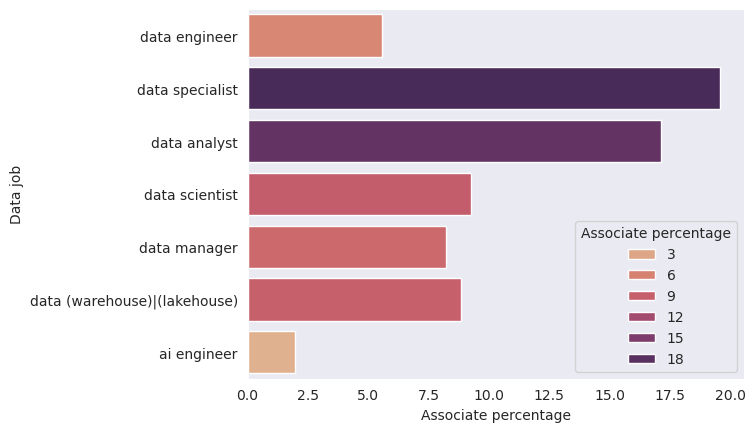

In [33]:
sns.barplot(assoc_pct,
            x = 'Associate percentage',
            y = 'Data job',
            hue = 'Associate percentage',
            palette="flare",
            orient = "y")

### The number of postings for each position

<Axes: xlabel='postings', ylabel='job_name'>

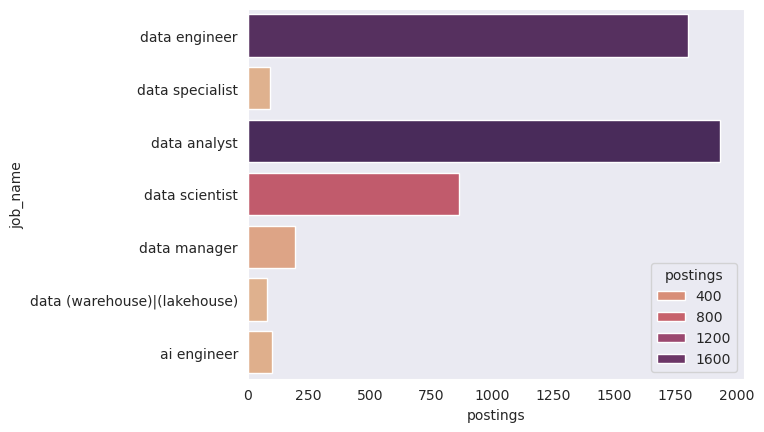

In [34]:
data = pd.DataFrame(counts)

sns.barplot(data,
            x = 'postings',
            y = 'job_name',
            hue = 'postings',
            palette='flare')

# CONCLUSION: 
- We can see that data analyst is by far the most welcoming to newcomers because of the high job counts and associate level postings
- Also, data engineers are very needed, however at least from the small portion for associate job postings, we can guess, that the market is more picky.
- Whereas, there are not a lot of AI engineer postings and a very small proportion of associaet positions.

## Most wanted skills by position

### Firstly, let's ascertain the most wanted skills any data position need
> Hopefully, data postings dataframe is smaller than 10MB(broadcast join limit)

In [35]:
joined = skills.join(broadcast(data_postings), 'link_hashed')
joined.cache()
joined.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+-------+---------------+--------------------+--------------------+-------------+----------+-----------+--------------+--------------------+----------+--------+-------------+---------------+------------+--------------+------------+----------------------------+-----------+
|         link_hashed|            job_link|          job_skills|            job_link| last_processed_time|got_summary|got_ner|is_being_worked|           job_title|             company| job_location|first_seen|search_city|search_country|     search_position| job_level|job_type|data engineer|data specialist|data analyst|data scientist|data manager|data (warehouse)|(lakehouse)|ai engineer|
+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+-------+---------------+--------------------+--------------------+-------------+----------+-----------

In [36]:
job_skills = joined.toPandas()
job_skills.head()

,link_hashed,job_link,job_skills,job_link,last_processed_time,got_summary,got_ner,is_being_worked,job_title,company,...,search_position,job_level,job_type,data engineer,data specialist,data analyst,data scientist,data manager,data (warehouse)|(lakehouse),ai engineer
0,6467027419517560022,https://www.linkedin.com/jobs/view/data-archit...,"[Data Architecture, SQL, Python, Snowflake,...",https://www.linkedin.com/jobs/view/data-archit...,2024-01-19 09:45:09.215838,True,True,False,Data Architect /Senior Data Engineer,"iSpace, Inc.",...,Architect,Mid senior,Onsite,True,False,False,False,False,False,False
1,2664778690826808253,https://www.linkedin.com/jobs/view/data-scient...,"[Data Analytics, Computer Science, Business ...",https://www.linkedin.com/jobs/view/data-scient...,2024-01-19 09:45:09.215838,True,True,False,Data Scientist,National Reconnaissance Office (NRO),...,Biologist,Associate,Onsite,False,False,False,True,False,False,False
2,914724932645535512,https://www.linkedin.com/jobs/view/senior-fina...,"[Accounting, Budgeting, Variance Analysis, ...",https://www.linkedin.com/jobs/view/senior-fina...,2024-01-19 09:45:09.215838,True,True,False,Senior Financial Healthcare Data Analyst I,HMSA,...,Accountant Cost,Mid senior,Onsite,False,False,True,False,False,False,False
3,-4848860201165402495,https://www.linkedin.com/jobs/view/associate-d...,"[Marketing, Machine Learning Engineering, Ga...",https://www.linkedin.com/jobs/view/associate-d...,2024-01-19 09:45:09.215838,True,True,False,Associate Data Scientist,Tencent,...,Biologist,Associate,Onsite,False,False,False,True,False,False,False
4,5737795617259112148,https://www.linkedin.com/jobs/view/rates-and-d...,"[Data acquisition, Data validation, Data tra...",https://www.linkedin.com/jobs/view/rates-and-d...,2024-01-19 09:45:09.215838,True,True,False,Rates and Data Analyst,City of Tacoma,...,Chief Librarian Branch Or Department,Associate,Onsite,False,False,True,False,False,False,False


In [37]:
import re

In [38]:
def transform_word(word):
    return re.sub(r'[^a-zA-Z\d\s\-]', '', word.lower())

In [39]:
def count_skills(arr: list[list[str]]) -> pd.DataFrame:
    skill_counts = {}
    
    for skills in arr:
        for skill in skills:
            skill = transform_word(skill)
            if skill in skill_counts:
                skill_counts[skill] += 1
            else:
                skill_counts[skill] = 1 
                
    skill_counts = pd.DataFrame({
        'skill': skill_counts.keys(),
        'count': skill_counts.values()
    })
    
    return skill_counts

In [40]:
skill_counts = count_skills(job_skills['job_skills'].values)   

In [41]:
skill_counts

,skill,count
0,data architecture,18
1,sql,2046
2,python,2050
3,snowflake,527
4,power bi,409
...,...,...
13044,blockchain,1
13045,angular js,1
13046,tsscifs poly,1
13047,data software solutions,1


Text(0.5, 1.0, 'Top 10 siklls for data jobs')

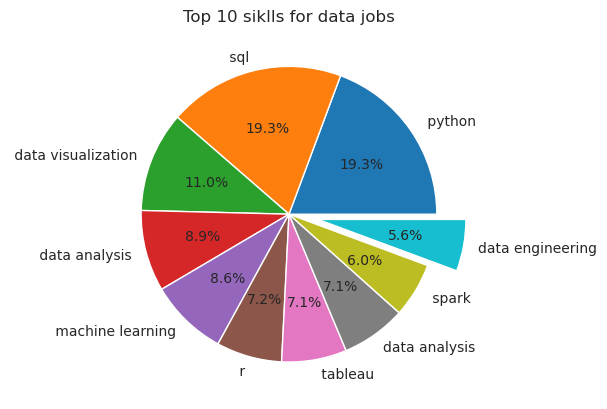

In [42]:
data = skill_counts.sort_values('count', ascending=False)\
    .head(10)

explode = [0] * 10
explode[9] = 0.2

plt.pie(x = data['count'],
        labels = data['skill'],
       autopct="%1.1f%%",
       explode = explode)
plt.title('Top 10 siklls for data jobs')

In [43]:
# Remove some data jobs from our radar for visualization sake
data_jobs = ['data engineer', 'data analyst', 'data scientist', 'ai engineer']

In [44]:
counts = pd.DataFrame(counts)
counts['postings_pct'] = counts['postings'] / counts['postings'].sum() * 100
counts_main = counts[counts['job_name'].isin(data_jobs)]

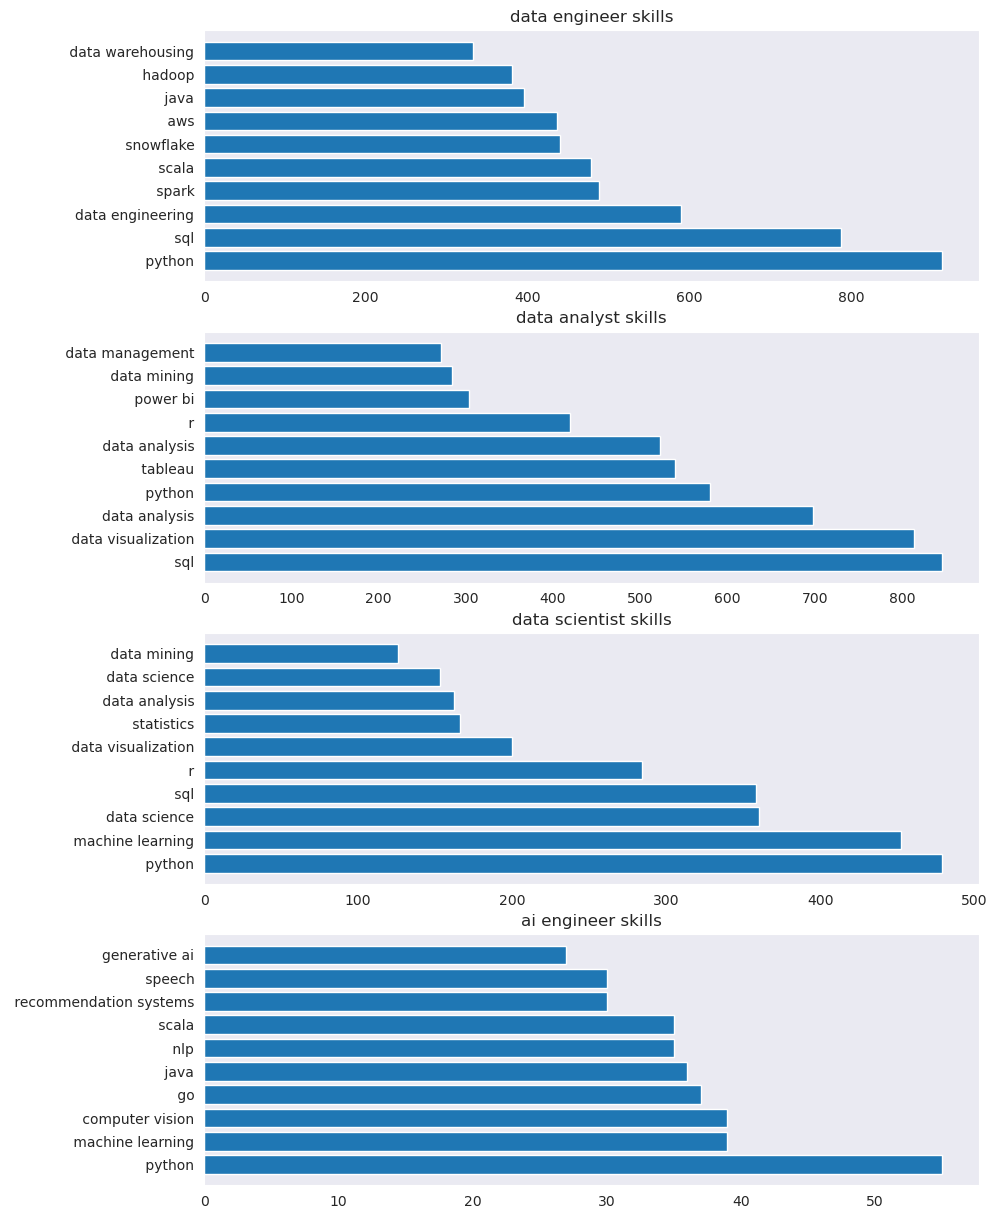

In [45]:
fig, axs = plt.subplots(nrows=4, figsize=(10, 15))

dfs = []
dfs_pct = []

for i, job in enumerate(data_jobs):
    mask = job_skills[job]
    data = job_skills[mask]

    skill_counts = count_skills(data['job_skills']) \
        .sort_values('count', ascending=False)
    dfs.append(skill_counts)

    axs[i].barh(width = skill_counts['count'].head(10),
               y = skill_counts['skill'].head(10))
    
    axs[i].set_title(f"{job} skills")

plt.show()

# CONCLUSION:
- The most popular skills in data jobs, by far, are SQL and Python
    - Therefore newcomers in the data field should have a strong foundation in these skills and education institutions and organizations, should focus on these skills early. 
- However, specific data jobs require a bit more, so at some - specialization is crucial
    -  For example, data engineering positions list Scala as an important skill, because Spark is natively written in Scala, however analysts and scientitst don't really have to know the language.
    -  R still is a tool, that some scientists and analysts use, however for data engineers and data warehouse developers it is a relatively uselesss skill. 

## Export datasets into CSV for Tableu visualization 

In [46]:
skills_df = pd.DataFrame({'skill': []})
pcts_df = pd.DataFrame({'skill': []})

for dframe, new_name in zip(dfs, data_jobs):
    dframe.columns = ['skill', new_name]
    
    skills_df = skills_df.merge(
                          dframe.sort_values(new_name, ascending=False)\
                                .head(10),
                          on='skill', how='outer')
    
    
    total_postings = counts[counts['job_name'].str.lower() == new_name]['postings']
    total_postings = total_postings.values[0]
    
    dframe[new_name] = dframe[new_name] / total_postings * 100
    pcts_df = pcts_df.merge(
                      dframe.head(10),
                      on='skill', how='outer')

In [47]:
skills_df = skills_df.fillna(0)
pcts_df = pcts_df.fillna(0) 

In [48]:
pcts_df.head()

,skill,data engineer,data analyst,data scientist,ai engineer
0,python,50.722222,30.005173,55.375723,54.455446
1,sql,43.777778,43.766167,41.387283,0.000000
2,data engineering,32.777778,0.000000,0.000000,0.000000
3,spark,27.166667,0.000000,0.000000,0.000000
4,scala,26.555556,0.000000,0.000000,34.653465


In [49]:
skills_df.columns = [x.capitalize().replace('Ai', 'AI') for x in skills_df.columns]
skills_df['Skill'] = skills_df['Skill']\
                        .map(lambda x: x.strip().capitalize())
pcts_df.columns = [x.capitalize().replace('Ai', 'AI') for x in skills_df.columns]
pcts_df['Skill'] = skills_df['Skill']\
                        .map(lambda x: x.strip().capitalize())

In [50]:
pcts_df.head()

,Skill,Data engineer,Data analyst,Data scientist,AI engineer
0,Python,50.722222,30.005173,55.375723,54.455446
1,Sql,43.777778,43.766167,41.387283,0.000000
2,Data engineering,32.777778,0.000000,0.000000,0.000000
3,Spark,27.166667,0.000000,0.000000,0.000000
4,Scala,26.555556,0.000000,0.000000,34.653465


In [51]:
skills_df = pd.melt(skills_df, id_vars=['Skill'], var_name='Position', value_name='Occured in postings')
pcts_df = pd.melt(pcts_df, id_vars=['Skill'], var_name='Position', value_name='Occured in postings')

In [52]:
skills_df['Occured in % postings'] = pcts_df['Occured in postings']
skills_df.head()

,Skill,Position,Occured in postings,Occured in % postings
0,Python,Data engineer,913.0,50.722222
1,Sql,Data engineer,788.0,43.777778
2,Data engineering,Data engineer,590.0,32.777778
3,Spark,Data engineer,489.0,27.166667
4,Scala,Data engineer,478.0,26.555556


In [59]:
skills_df = skills_df.sort_values('Occured in postings', ascending=False)

In [60]:
skills_df.to_csv('data/skills.csv')

In [54]:
counts['assoc_pct'] = assoc_pct['Associate percentage']
counts

,job_name,postings,postings_pct,assoc_pct
0,data engineer,1800,35.538006,5.555556
1,data specialist,92,1.816387,19.565217
2,data analyst,1933,38.163870,17.123642
3,data scientist,865,17.077986,9.248555
4,data manager,195,3.849951,8.205128
5,data (warehouse)|(lakehouse),79,1.559724,8.860759
6,ai engineer,101,1.994077,1.980198


In [55]:
counts['job_name'] = counts['job_name'].map(lambda x: x.capitalize().replace('(warehouse)|(lakehouse)', 'warehouse'))

In [56]:
counts.to_csv('data/aggregate.csv')